# QamomileにおけるQuTiPTranspilerの使用方法

QamomileとQuTiPを用いた量子アニーリングの応用を紹介します。ここでは、以下の形式のハミルトニアンに注目します：

$$
H(s) = s H_0 + (1 - s) H_1
$$

ここで $H_0$ は解きたいMax-Cut問題のハミルトニアンであり、しばしばイジングモデルの形式で定式化されます。一方、$H_1$ は横磁場のハミルトニアンです。Max-Cut問題のハミルトニアンの構築方法の詳細については、[QAOA for Max-Cut](https://jij-inc.github.io/Qamomile/ja/tutorial/maxcut.html) を参照してください。  
ハミルトニアンは次のように定義されます：

$$
H_0 = -\frac{1}{2} \sum_{(i,j) \in E} w_{i,j}(1 - s_i s_j)  , \quad H_1 = - \sum_{i=1}^N \sigma_i^x
$$

パラメータ $s$ が0から1に徐々に変化することで、系は $H_1$ の基底状態から $H_0$ の基底状態、すなわち最適化問題の解へと漸進的に進化します。

まずは、Qamomileライブラリとこの例で使用するその他のライブラリをインポートします。


In [1]:
from IPython.display import display, Latex
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qutip import tensor, Qobj, mesolve

import qamomile.core as qm
from qamomile.core.bitssample import BitsSample, BitsSampleSet
import qamomile.core.operator as qm_o
import qamomile.qutip as qm_qt

## MaxCut問題の定式化と量子形式への変換

In [2]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    w = jm.Placeholder("w", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)

    problem = jm.Problem("Maxcut")
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = -1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

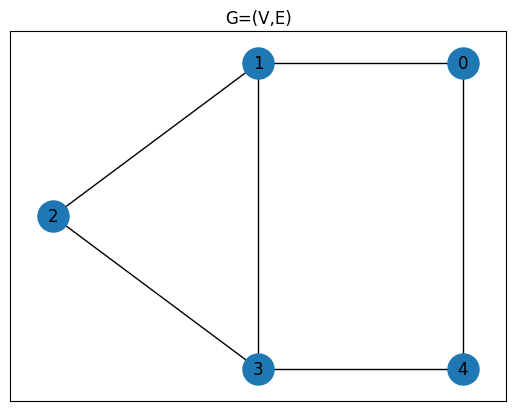

In [3]:
G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)

In [4]:
interpreter = jm.Interpreter({"V": num_nodes, "E": edges})
compiled_model = interpreter.eval_problem(problem)

In [5]:
# 損失ハミルトニアンを取得する
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)
H0 = qaoa_converter.get_cost_hamiltonian()

次に、QamomileのハミルトニアンをQuTiPのハミルトニアンへ変換します。

In [6]:
qt_transpiler = qm_qt.QuTiPTranspiler()
qt_H0= qt_transpiler.transpile_hamiltonian(H0)

横磁場のハミルトニアン $H_1$ も構築する必要があります。

In [7]:
H1 = qm_o.Hamiltonian()
for q1 in range(num_nodes):
    H1 -= qm_o.X(q1)
qt_H1= qt_transpiler.transpile_hamiltonian(H1)

先ほど導入したハミルトニアン $H(s)$ のパラメータ $s = t / T$ として、アニーリング時間 $T$ を定義します。量子アニーリングにおいて、$T$ を十分大きく取れば、理論的には $H_0$ の基底状態を得ることができます。Max-Cut問題に対して量子アニーリングを行い、最終状態 $|\psi(T)\rangle$ が問題の最適解となっているかを検証します。

量子アニーリング全体のハミルトニアンは、各要素がハミルトニアンとその係数のペアとなるリストとして表されます。また、時刻 $t = 0$ における初期状態 $ \psi(t) $ を作成します。これは $H_1$ の基底状態です。

In [8]:
T=100

def coef0(t, args):
    return t/T

def coef1(t, args):
    return 1-t/T

H = [[qt_H0, coef0], [qt_H1, coef1]]
psi0 = tensor([Qobj([[1], [1]])/np.sqrt(2) for _ in range(num_nodes)])

シュレディンガー方程式を解くために、ハミルトニアン、初期状態、および時間のリストを用いて`mesolve`を使用します。

In [9]:
tlist = np.linspace(0.0, T, 101)
result = mesolve(H, psi0, tlist, [])
psi_final = result.states[-1]

アニーリング後の最終状態の確率分布を可視化することができます。

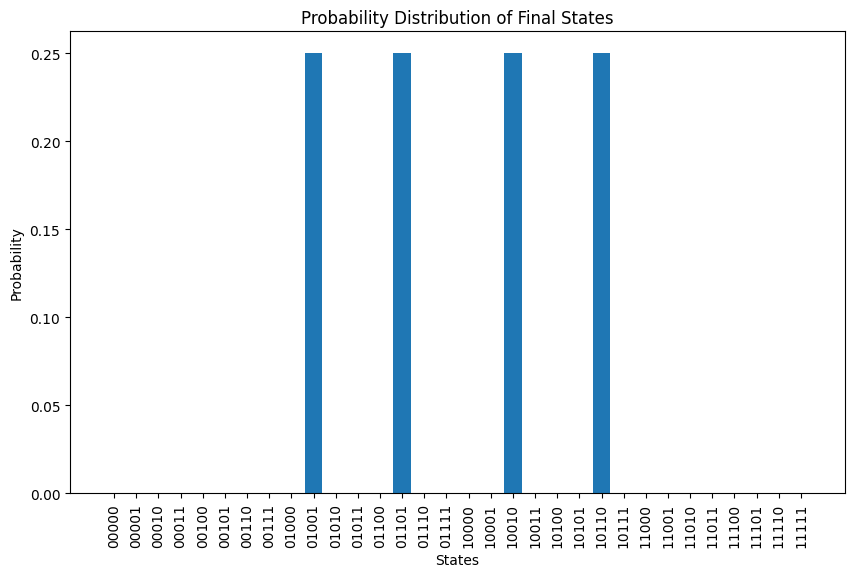

In [10]:
probs = np.abs(psi_final.full())**2
plt.figure(figsize=(10, 6))
basis_labels = [f"{i:0{num_nodes}b}" for i in range(2**num_nodes)]
bars=plt.bar(range(len(probs)), probs.flatten())
plt.xticks(ticks=range(len(probs)), labels=basis_labels, rotation=90)
plt.xlabel("States")
plt.ylabel("Probability")
plt.title("Probability Distribution of Final States")

plt.show()

最終状態とそれに対応する確率は以下の通りです：

In [11]:
final_states = []
for bar, label in zip(bars, basis_labels):
    if bar.get_height() > 1e-4:
        print(f"Final state: {label}, Probability: {bar.get_height():.4f}")
        array_label = np.array([int(bit) for bit in label])
        final_states.append((array_label, bar.get_height())) 

Final state: 01001, Probability: 0.2500
Final state: 01101, Probability: 0.2500
Final state: 10010, Probability: 0.2500
Final state: 10110, Probability: 0.2500


結果によると、4つの縮退した解が存在します。それらすべての解を可視化してみましょう。その際、[QAOA](https://jij-inc.github.io/Qamomile/tutorial/maxcut.html) を用いて得られた結果を参考にすることができます。

In [12]:
from qamomile.core.bitssample import BitsSample,BitsSampleSet
samples = []
for state,prob in final_states:
    sample = BitsSample(bits=state, num_occurrences=1)
    samples.append(sample)

sample_set = BitsSampleSet(samples)
ommx_sample_set = qaoa_converter.decode_bits_to_sampleset(sample_set)

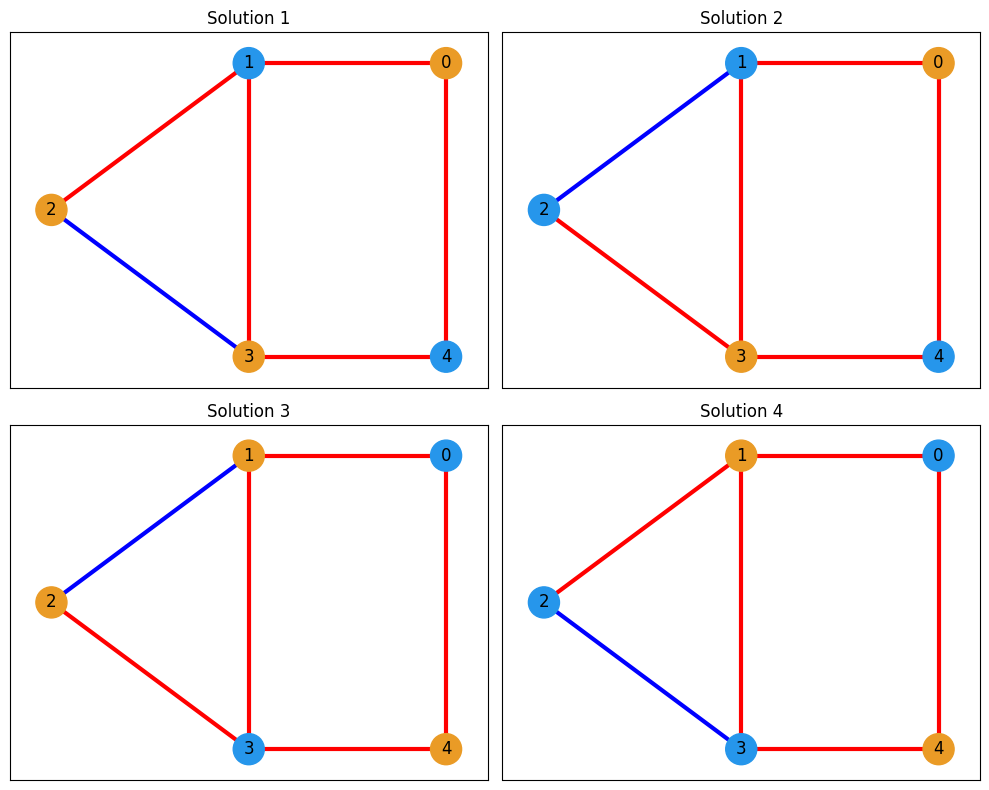

In [13]:
edge_colors = []

def get_edge_colors(graph, cut_solution, in_cut_color="r", not_in_cut_color="b"):
    cut_set_1 = [node for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
            
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9B26" for node in graph.nodes()]
    return edge_colors, node_colors

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
axes = axes.flatten()

for i, sample_id in enumerate(ommx_sample_set.sample_ids):
    solution = ommx_sample_set.get_sample_by_id(sample_id)
    
    edge_colors, node_colors = get_edge_colors(G, solution.state.entries)
    
    # Create the plot
    ax = axes[i]  # Select subplot
    ax.set_title(f"Solution {i+1}")
    
    nx.draw_networkx(
        G,
        pos,
        node_size=500,
        width=3,
        with_labels=True,
        edge_color=edge_colors,
        node_color=node_colors,
        ax=ax,
    )

plt.tight_layout()
plt.show()

また、`eigenenergies`で計算されたエネルギースペクトル上で、パラメータ $s$ が0から1に変化するにつれてハミルトニアンの固有エネルギーがどのように変化するかを可視化することもできます。

In [14]:
slist = np.linspace(0.0, 1.0, 101)
enegry_list = [[] for i in range(2**num_nodes)]

for s in slist:
    qt_H = s*qt_H0 + (1-s)*qt_H1
    enegry = qt_H.eigenenergies()
    for i in range(2**num_nodes):
        enegry_list[i].append(enegry[i])

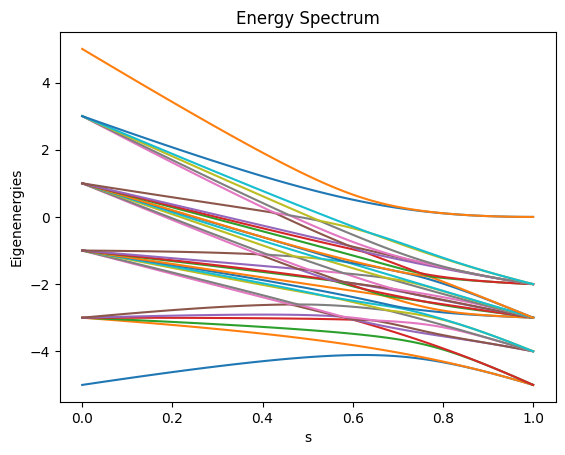

In [15]:
for i in range(2**num_nodes):
    plt.plot(slist, enegry_list[i], label=f"{i+1}th")

plt.xlabel("s")
plt.ylabel("Eigenenergies")
plt.title("Energy Spectrum")
plt.show()

同じ最低エネルギー準位を共有する縮退した状態が4つ存在することがわかり、これはアニーリングの結果と一致しています。

Masaphys. *PythonとQuTiPで量子アニーリングのダイナミクスを追う*. Qiita. Accessed October 30, 2024. [https://qiita.com/masaphys/items/38aeaee5313f81e15414](https://qiita.com/masaphys/items/38aeaee5313f81e15414)
